In [12]:
import pandas
from itertools import izip
from collections import Counter
import pylab as plt
import numpy as np
import h5py
        
def img_show( img, **kwargs):
    plt.figure(figsize=(16,16))
    plt.imshow( img, **kwargs)
    plt.colorbar()
    plt.show()
    

# this is a peakbook class that reads in cheetah ssshit to 
# plot the peaks and see what the cheetah is doing... 

class PeakBook:
    def __init__(self, peaks_fname):
        """
        peaks_fname: peaks.txt from a cheetah 
        """
        self.peaks = pandas.read_csv(peaks_fname, sep=',', skipinitialspace=1 )
        self.peaks.rename(columns={'# frameNumber': 'frameNumber'}, inplace=1) # pandas no like pound sign in column names
    
    
    def get_pk_imgs(self,img, fr):
        """
        returns a list of 2D images of peaks
        
        img  -  2D cheetah raw image found in CXI file /event_1/data_1/data
        fr - frame number of hit, found in CXI file /cheetah/event_data/frameNumber
        """
        pks_fr = self.peaks.query('frameNumber==%d'%fr)
        pk_x, pk_y, pk_n = pks_fr.peak_x_raw, pks_fr.peak_y_raw, pks_fr.nPixels

        self.sub_imgs = []
        for x,y,d in izip( pk_x, pk_y, pk_n):
            sub_img = img[int(y)-d:int(y)+d, int(x)-d:int(x)+d]
            self.sub_imgs.append( sub_img)
        return self.sub_imgs
    
    def isolate_pk_imgs(self,img, fr):
        """
        returns a new image where only the peaks (and profiles) are shown, all other pixels are 0..
        
        img  -  2D cheetah raw image found in CXI file /event_1/data_1/data
        fr - frame number of hit, found in CXI file /cheetah/event_data/frameNumber
        """
        pks_fr = self.peaks.query('frameNumber==%d'%fr)
        pk_x, pk_y, pk_n = pks_fr.peak_x_raw, pks_fr.peak_y_raw, pks_fr.nPixels

        new_img = np.zeros_like( img)
        
        for x,y,d in izip( pk_x, pk_y, pk_n):
            new_img[int(y)-d:int(y)+d, int(x)-d:int(x)+d] = \
                img[int(y)-d:int(y)+d, int(x)-d:int(x)+d]
            
        return new_img
    
    def plot_subimgs(self, save_fname):
        """
        save_fname, pdf filename for saving the peakbook so you can view it... 
        """
        
        nimg = len(self.sub_imgs)
        
        nrows = ncols = int(np.ceil(np.sqrt(nimg)))
        
        fig, axes = plt.subplots( nrows=nrows, ncols=ncols, figsize= ( nrows**2,ncols**2) )

        for i,(img,ax) in enumerate(zip( self.sub_imgs, axes.flat)):
            im = ax.imshow( img, cmap='gnuplot', vmin=0, vmax=500, interpolation='nearest')
            #ax.set_title('hit%d'%idx, fontsize=16, y=.98)
            ax.axis('off')
            if i == nimg:
                break

        plt.subplots_adjust( hspace=0.2, wspace=0.05, right=0.92)
        cbar_ax = fig.add_axes([0.93, 0.15, 0.025, 0.7])
        cbar =fig.colorbar(im, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=22)
    
        plt.savefig(save_fname)
        plt.clf()
        print("File saved as %s"%save_fname)
        
    
def special_powder(cxi_fname, peaks_fname, max_hit, gain_f = None):
    """
    cxi_fname, path to a cxi file
    peaks_fname, path to a peaks.txt file, corresponding to cxi file
    max_hit, maximum number of hits to sum
    gain_f, path to a gain file.. 
    """
    
    PB = PeakBook(peaks_fname)
    cxi = h5py.File( cxi_fname, 'r')
    raw_path = 'entry_1/data_1/data'
    hits = cxi[raw_path] # dont worry its a dataset so its not all loaded into mem...
    frame = cxi['cheetah/event_data/frameNumber'].value
    gen = izip(hits, frame)
    
    assert (frames.size)
    # load the first hit, skip the frame
    iso_hits, _ = gen.next()
    
    if gain_f is not None:
        gain = h5py.File(gain_f, 'r')['data/data'].value
    else:
        gain = np.ones_like( iso_hits)
    iso_hits /= gain
    
    for i, (hit, fr)  in enumerate(  izip( hits, frame) ):
        if i == max_hit:
            break
        iso_hits += PB.isolate_pk_imgs( hit, fr) / gain
    return iso_hits


class AssGeom:
    def __init__(self, geom_f, base=256, pixsize=0.000110):
        geom = h5py.File(geom_f, 'r') # load geometry file
        """
        geom_f, pasth to cheetah geom file geometry.h5 or whatever///
        base, assembled geom will have a "multiple number base" pixels in each directon
        pixsize, size of pixels in meters
        
        """
        self.Px = geom['x'].value / pixsize # pixel units along fast scan
        self.Py = geom['y'].value / pixsize # pixel units along slow scan

        # this finds a suitable dimension of the detector such that we capture all the pixels
        self.dim = 2*max( abs( min( [self.Px.min(), self.Py.min()]) ),  max( [self.Px.max(), self.Py.max()]) ) + 1
        # this rounds dim up to  a computational efficient unit (in case we want to bin-reduce later)
        self.dim = int( np.ceil( self.dim/base) * base )

    def ass(self, raw):
        """
        assemble a raw image..
        
        raw, 2D raw panel array found in CXI files...
        """
        return np.histogram2d(self.Py.ravel(), self.Px.ravel(), bins=self.dim, 
                              range=[ [-self.dim/2, self.dim/2], [-self.dim/2, self.dim/2]],
                              weights=raw.ravel())[0]
    

#def max_composite_img_list( cxi_list, peaks_list ):
#    """
#    Returns an image where each pixel is maximized 
#    across multiple datasets
#    
#    cxi_list, list of cheetah .cxi files
#    peaks_list, list of cheetah peaks.txt files, one per
#        cxi file
#    """
#    assert( len(cxi_list) == len( peaks_list))
##   imgs = []
#    for cxi_fname, peaks_fname in zip( cxi_list, peaks_list):
#        max_comp_img = max_composite_img(cxi_fname, peaks_fname)
#        imgs.append( max_comp_img)#

#    return np.max( imgs, axis=0)

    
def max_composite_img(cxi_fname, peaks_fname):
    """
    Makes an image where each pixel is maximized
    according to its values across a dataset
    
    cxi_fname, path to a cheetah cxi file,
    peaks_fname, path to a cheetah peaks.txt file, corresponding to cxi file,
    max_hit, maximum number of hits to sum
    """
    
    PB = PeakBook(peaks_fname)
    cxi = h5py.File( cxi_fname, 'r')
    
    raw_path = 'entry_1/data_1/data'
    hits = cxi[raw_path] # dont worry its a dataset so its not all loaded into mem...
    frame = cxi['cheetah/event_data/frameNumber'].value
    
    ## MAX composite image
    max_comp_img = np.zeros( hits[0].shape)
    for hit,fr in izip(hits, frame):
        img = PB.isolate_pk_imgs(hit, fr)
        max_comp_img = np.max( [max_comp_img, img], axis=0 )
    
    return max_comp_img


def save_iso_imgs(cxi_fname, peaks_fname, geom_fname, out_fname, max_hit=0, gauss_sig=0.85):
    """
    Make Isolated peak images with optional Gaussian smoothing
       
    cxi_fname, path to a cheetah cxi file,
    peaks_fname, path to a cheetah peaks.txt file, corresponding to cxi file,
    geom_fname, path to cheetah geom file
    out_fname, path to output compressed hdf5 file
    
    max_hit, maximum number of hits to save
    gauss_sig, gauss smooth parameter, pixel units, default=0.85, set 
        to 0.0 to disable
    """
    
    from scipy.ndimage.filters import gaussian_filter as GF
    from itertools import izip
    import h5py
    
    # load the peak book
    PB = PeakBook(peaks_fname)
    # load the data file
    cxi = h5py.File( cxi_fname, 'r')
    
    # load the datasets...
    hits = cxi['entry_1/data_1/data'] # dont worry its a dataset so its not all loaded into mem...
    frames = cxi['cheetah/event_data/frameNumber'].value
    
    # load the image assembler
    AG = AssGeom(geom_fname)
    
    with h5py.File(out_fname, 'w') as out:
        for i_hit, (hit,fr) in enumerate( izip(hits, frames)):
            # isolate the peaks
            iso_img = PB.isolate_pk_imgs(hit,fr)
            # assemble the image
            ass_iso = AG.ass(iso_img)
            # optionally smooth the image
            smo_iso = GF(ass_iso, sigma=.85)
            # save the image...
            out.create_dataset("AssHit%d"%i_hit, data=smo_iso.astype(np.float32),
                            compression='gzip', compression_opts=9, fillvalue=0)
            
            if i_hit == max_hit:
                break
        
    

In [13]:

# initialize the peak book
run_path = './r0057-ps2'

# peaks
peaks_f = '%s/peaks.txt'%run_path
#cxi
cxi_f = '%s/mfxn1116-r0057-c00.cxi'%run_path

#geom_f
geom_f = '%s/geometry.h5'%run_path

# output
out_f = './output_test.hdf5'

save_iso_imgs(cxi_f, peaks_f, geom_f, out_f, max_hit=200)


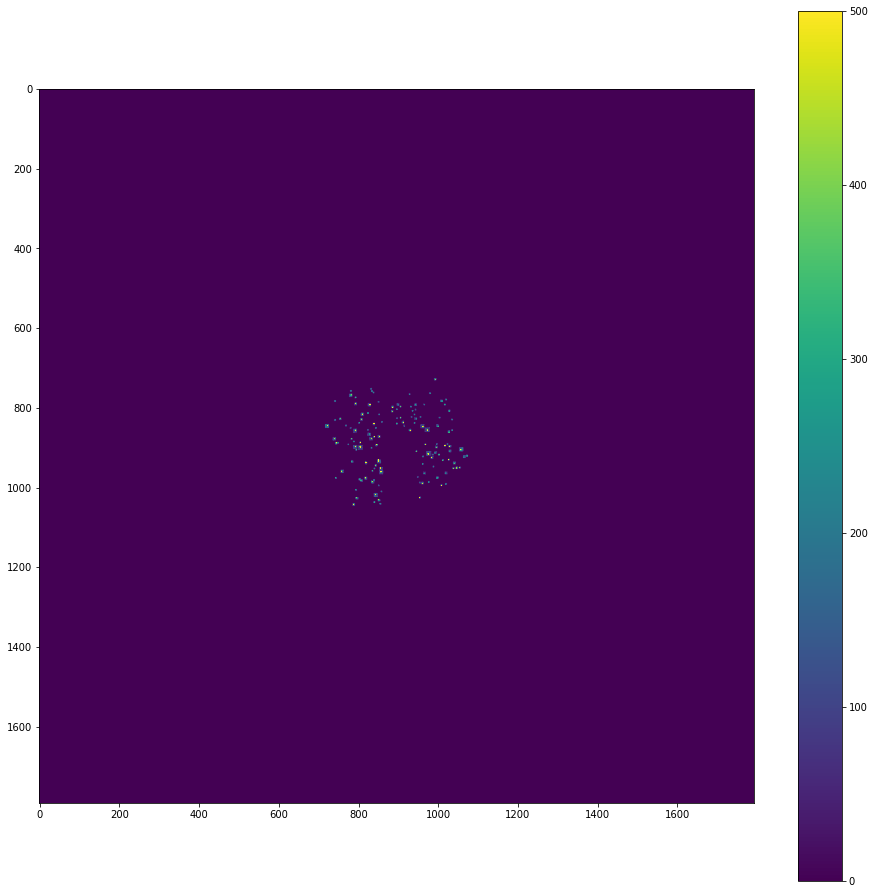

In [17]:
f  = h5py.File('output_test.hdf5','r')
img = f['AssHit1'].value
img_show(img, vmax=500)

In [40]:
from collections import Counter
C = Counter(PB.peaks.frameNumber)
most = sorted( C.items(),key=lambda x: x[1] )[-1]
print("Frame number %d has the most detected peaks: %d peaks"%most)

max_fr = most[0]

Frame number 38232 has the most detected peaks: 456 peaks


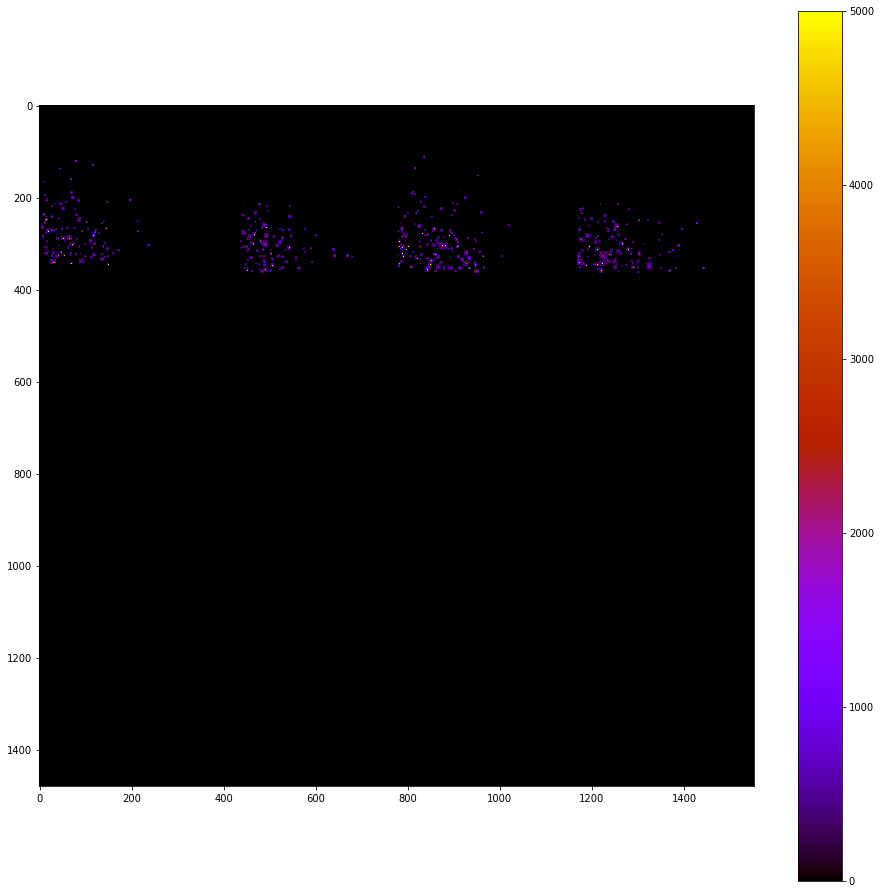

In [41]:
# lets find the index of the image dataset that corresponds to the frame with most peaks... 
max_idx = np.where( frame == max_fr )[0][0]
iso_img = PB.isolate_pk_imgs(hits[max_idx], max_fr)
img_show( iso_img, vmax=5000, cmap='gnuplot')

In [4]:
# next we can bin this image onto a CSPAD detector geometry

geom = h5py.File('%s/geometry.h5'%run_path, 'r') # load geometry file
pixsize = 0.000110 # metre
base = 256 # 2D detector array will be a multiple of this
Px = geom['x'].value / pixsize # pixel units along fast scan
Py = geom['y'].value / pixsize # pixel units along slow scan

# this finds a suitable dimension of the detector such that we capture all the pixels
dim = 2*max( abs( min( [Px.min(), Py.min()]) ),  max( [Px.max(), Py.max()]) ) + 1
# this rounds dim up to  a computational efficient unit (in case we want to bin-reduce later)
dim = int( np.ceil( dim/base) * base )

# here is the function now, which assembled the image.. 
def ass(raw):
    """assemble a raw image.."""
    return np.histogram2d(Py.ravel(), Px.ravel(), bins=dim, 
                          range=[ [-dim/2, dim/2], [-dim/2, dim/2]],
                          weights=raw.ravel())[0]

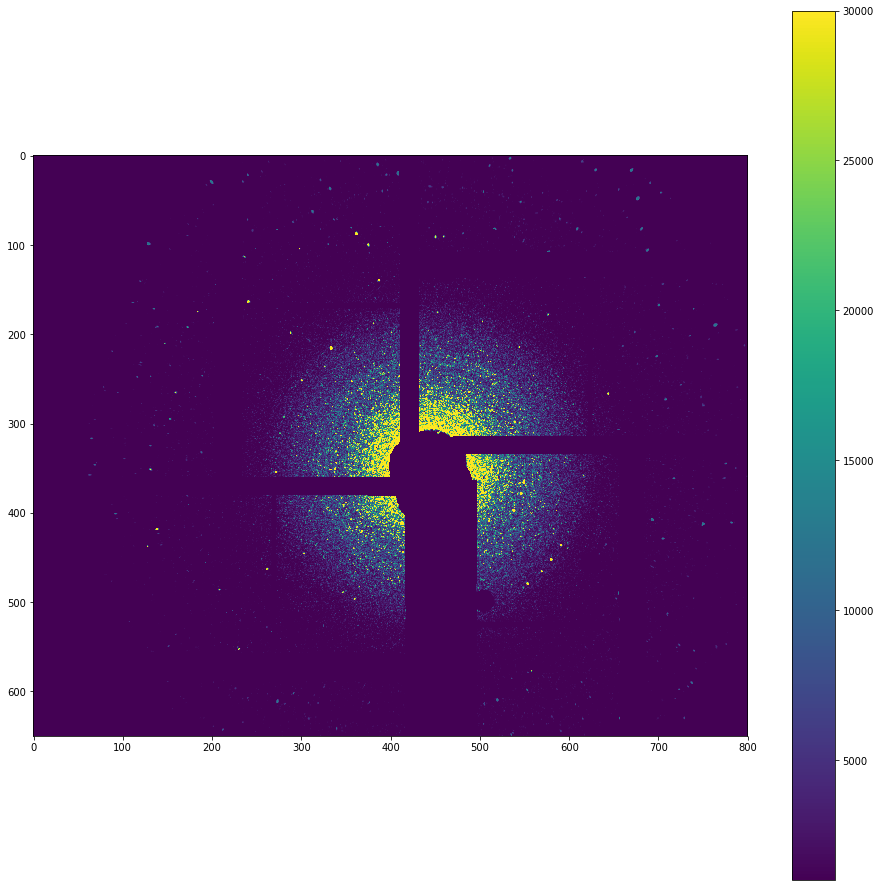

In [14]:
max_ass_img = ass(max_comp_img)
sY = slice(550,1200,1)
sX = slice(450,1250,1)
img_show(max_ass_img[sY, sX], vmin=1000, vmax=30000)

In [45]:
ass_iso = ass( iso_img)
ass_iso[ ass_iso >= 2**14] = 0

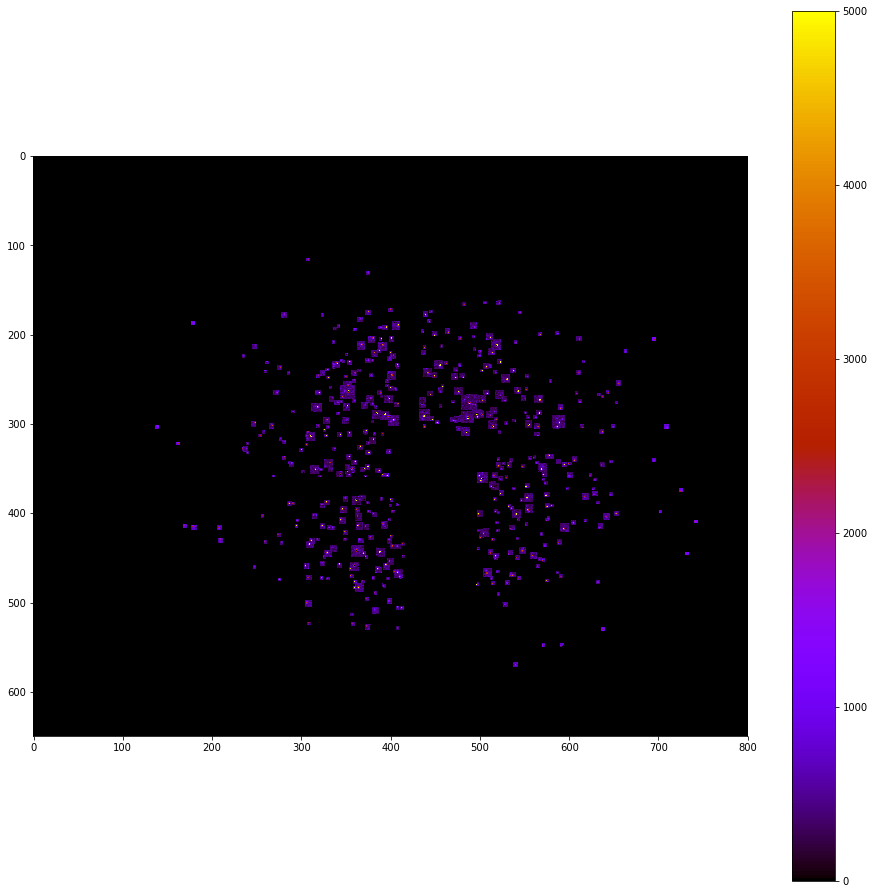

In [55]:
# image slices
sY = slice(550,1200,1)
sX = slice(450,1250,1)
img_show( ass_iso[sY, sX], vmax=5000, cmap='gnuplot')

In [ ]:
# are there any negatives?
assert( not np.any( ass_iso < 0 ) )

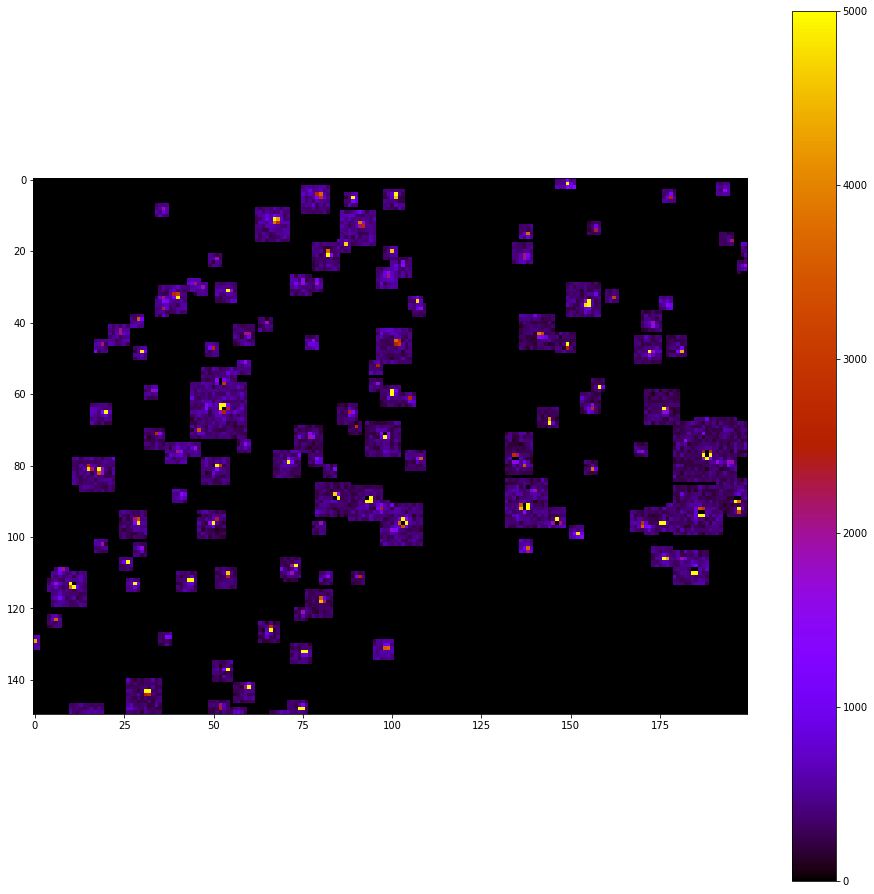

In [65]:
# ok no negative values.. thats good. Now lets smooth (this might hurt indexing but we'll see)

# first zoom in on some peaks
sY = slice(750,900,1)
sX = slice(750,950,1)
img_show( ass_iso[sY, sX], cmap='gnuplot', vmax=5000)

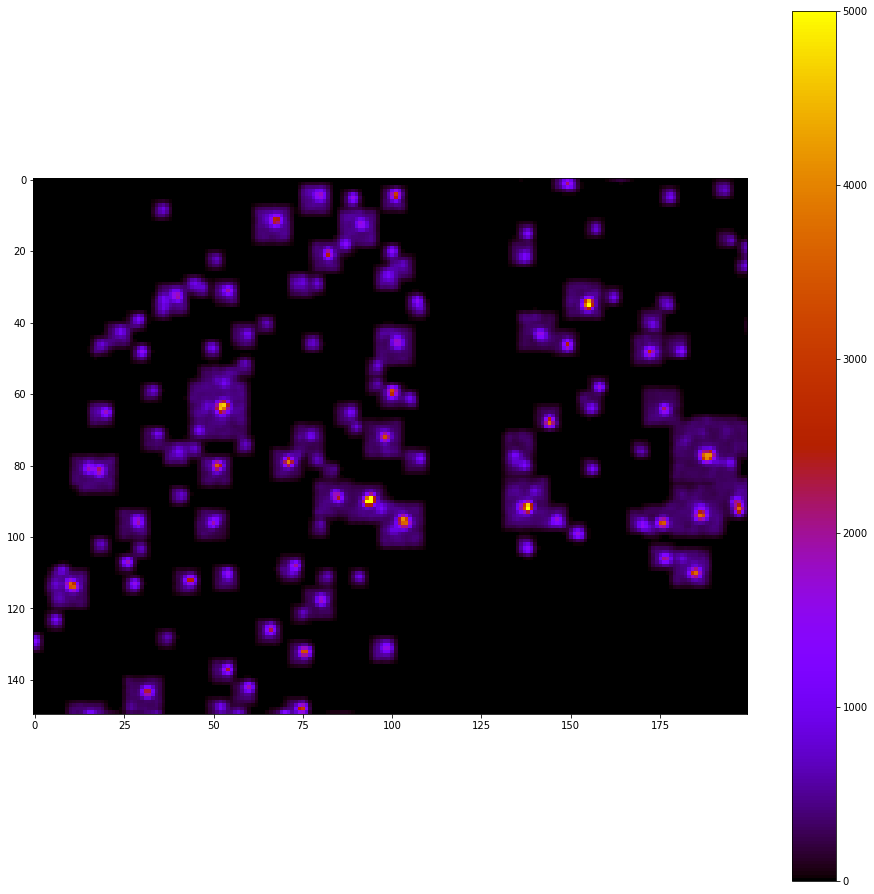

In [68]:
from scipy.ndimage.filters import gaussian_filter as GF
smo_iso = GF(ass_iso, sigma=.85) # smear around by about a pixel or so...
img_show( smo_iso[sY, sX], cmap='gnuplot', vmax=5000)

In [69]:
# now we can try to index... e deirst we need the "origin"